In [21]:


# Libraries

import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import transforms


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline



# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [27]:


# Data Transformer
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [28]:
TRAIN_ROOT = r"C:\Users\91937\Downloads\HTAProject\Split_dataset2\train"
TEST_ROOT = r"C:\Users\91937\Downloads\HTAProject\Split_dataset2\test"

train_ds = ImageFolder(TRAIN_ROOT, transform=transformer)
test_ds = ImageFolder(TEST_ROOT, transform=transformer)

In [29]:

# Length of Train and Test Datasets
LEN_TRAIN = len(train_ds)
LEN_TEST = len(test_ds)
print(LEN_TRAIN, LEN_TEST)

# Index Mapping
print(train_ds.class_to_idx)



615 143
{'Acinetobacter.baumanii': 0, 'Actinomyces.israeli': 1, 'Bacteroides.fragilis': 2, 'Bifidobacterium.spp': 3, 'Candida.albicans': 4, 'Clostridium.perfringens': 5, 'Enterococcus.faecalis': 6, 'Enterococcus.faecium': 7, 'Escherichia.coli': 8, 'Fusobacterium': 9, 'Lactobacillus.casei': 10, 'Lactobacillus.crispatus': 11, 'Lactobacillus.delbrueckii': 12, 'Lactobacillus.gasseri': 13, 'Lactobacillus.jehnsenii': 14, 'Lactobacillus.johnsonii': 15, 'Lactobacillus.paracasei': 16, 'Lactobacillus.plantarum': 17, 'Lactobacillus.reuteri': 18, 'Lactobacillus.rhamnosus': 19, 'Lactobacillus.salivarius': 20, 'Listeria.monocytogenes': 21, 'Micrococcus.spp': 22, 'Neisseria.gonorrhoeae': 23, 'Porfyromonas.gingivalis': 24, 'Propionibacterium.acnes': 25, 'Proteus': 26, 'Pseudomonas.aeruginosa': 27, 'Staphylococcus.aureus': 28, 'Staphylococcus.epidermidis': 29, 'Staphylococcus.saprophiticus': 30, 'Streptococcus.agalactiae': 31, 'Veionella': 32}


In [30]:
# Data Loader
train_loader = DataLoader(train_ds, batch_size = 30, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=30, shuffle = True)

In [31]:


# Model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Replace Output of Fully Connected Layer with Number of Labels for our Classification Problem
model.fc = Linear(in_features=512, out_features=33)
model = model.to(device)
model = model.cuda()

In [32]:


# Optimiser
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Loss Function
loss_fn = CrossEntropyLoss()


# 
Step 4: Train & Evaluate the Model

In [33]:

for epoch in range(3):
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_TEST
    
    end = time()
    duration = (end - start) / 60
    
    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {ep_test_acc}")


100%|██████████| 21/21 [00:28<00:00,  1.34s/batch]


Epoch: 0, Time: 0.5846090873082479, Loss: 0.6456527709960938
Train_acc: 0.5788617886178862, Test_acc: 0.7972027972027972


100%|██████████| 21/21 [00:30<00:00,  1.44s/batch]


Epoch: 1, Time: 0.6559593836466472, Loss: 0.3938531279563904
Train_acc: 0.8666666666666667, Test_acc: 0.9090909090909091


100%|██████████| 21/21 [00:36<00:00,  1.74s/batch]


Epoch: 2, Time: 0.7624652703603109, Loss: 0.5116465091705322
Train_acc: 0.9203252032520325, Test_acc: 0.951048951048951


# Model Performance on Samples

In [34]:


# Image Samples
sample_1 = r'C:\Users\91937\Downloads\HTAProject\Split_dataset\val\Enterococcus.faecium\Enterococcus.faecium_0006.tif'
sample_2 = r"C:\Users\91937\Downloads\HTAProject\Split_dataset\val\Streptococcus.agalactiae\Streptococcus.agalactiae_0006.tif"
sample_3 = r"C:\Users\91937\Downloads\HTAProject\Split_dataset\val\Neisseria.gonorrhoeae\Neisseria.gonorrhoeae_0006.tif"
sample_4 = r'C:\Users\91937\Downloads\HTAProject\Split_dataset\val\Lactobacillus.johnsonii\Lactobacillus.johnsonii_0006.tif'

sample_list = [sample_1,sample_2,sample_3,sample_4]


In [39]:
values = {v: k for k, v in train_ds.class_to_idx.items()}

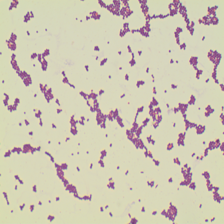

Model prediction 7, Enterococcus.faecium


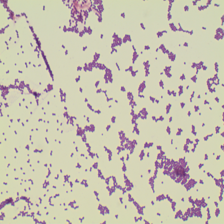

Model prediction 5, Clostridium.perfringens


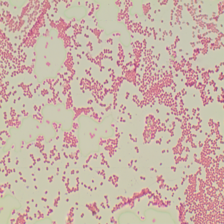

Model prediction 23, Neisseria.gonorrhoeae


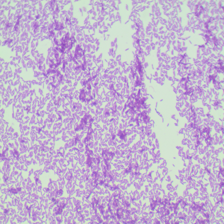

Model prediction 15, Lactobacillus.johnsonii


In [40]:
# Model Performance
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img.resize((224,224)))
    img_tensor = transformer(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    if pred in values.keys():
        print(f"Model prediction {pred}, {values[pred]}")
    else:
        print(f"wrong")

    print("========================================================")